In [1]:
#Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic
from sklearn.impute import SimpleImputer

# Условие

- Реализовать расчеты способами а и б для набора данных из файла insclass_train.csv/
2- Для 151 406 договоров страхования транспортных средств известны значения ряда признаков,
в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель,
год выпуска, страна – производитель, мощность и объем двигателя, а также признак target, равный 1,
 если заключение договора с клиентом является рисковым, и 0 в противном случае (файл insclass_train.csv).

- Требуется построить модель, предсказывающую значение признака target для 22 624 договоров из тестового набора данных (файл insclass_test.csv).

- В обучающем наборе данных для каждого договора известны следующие поля:

variable_1 - агрегированный коэффициент бонус-малус (повышающий или понижающий стоимость полиса в зависимости от аварийности в предыдущие периоды);

variable_2 - индикатор расторжения договора по инициативе страхователя (клиента);

variable_3 - индикатор расторжения договора по инициативе страховщика (страховой компании);

variable_4 - идентификатор года выпуска транспортного средства;

variable_5 - идентификатор страны - производителя транспортного средства;

variable_6 - мощность двигателя в лошадиных силах;

variable_7 - объем двигателя в куб. см;

variable_8 - идентификатор стороны расположения руля (левый или правый);

variable_9 - пробег транспортного средства, покрываемый гарантией производителя;

variable_10 - индикатор действия гарантии на транспортное средство;

variable_11 - "мультидрайв" - индикатор допуска к управлению транспортным средством более одного водителя;

variable_12 - возраст транспортного средства (в мес.);

variable_13 - возраст водителя с максимальным стажем;

variable_14 - коэффициент возраст-стаж;

variable_15 - коэффициент краткосрочности;

variable_16 - коэффициент мощности;

variable_17 - коэффициент "мультидрайв";

variable_18 - территориальный коэффициент;

variable_19 - коэффициент "КНДР";

variable_20 - идентификатор канала продаж;

variable_21 - марка транспортного средства;

variable_22 - модель транспортного средства;

variable_23 - индикатор отечественных транспортных средств;

variable_24 - пол водителя с максимальным коэффициентом "возраст-стаж";

variable_25 - индикатор пролонгации;

variable_26 - индикатор совпадения собственника транспортного средства и водителя;

variable_27 - стаж водителя с максимальным коэффициентом "возраст-стаж";

variable_28 - тип транспортного средства;

target - класс риска, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае.

In [2]:
TEST_DATA_NUM = 22624

# Подготовка данных 

### 1 Уничтожаем NaN

In [3]:
init_df = pd.read_csv('insclass_train.csv')
# считаем кол-во NaN
keys_with_nan = init_df.isna().sum()    
# ic(f'All NaN sum \n{keys_with_nan}')
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan


variable_6        111
variable_7      95639
variable_8      29899
variable_9     134436
variable_12      1528
variable_13      1657
variable_14      2927
variable_15    151393
variable_16        12
variable_17        12
variable_18        12
variable_20         1
variable_24      2207
variable_27      2067
dtype: int64

In [4]:
refacted_df = init_df.copy().drop(['variable_9', 'variable_15'], axis=1)
keys_with_nan = keys_with_nan.drop(labels=['variable_9', 'variable_15'])
refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,w200,0,0,14,q2,98.0,NaN,0.0,0,0,...,C,j2,h45,0,0.0,0,1,19.323463,t1,0
1,w160,0,0,7,q11,106.0,NaN,0.0,0,0,...,C,j33,h234,0,1.0,0,1,41.177900,t1,0
2,w200,0,0,4,q3,123.0,NaN,0.0,0,0,...,B,j12,h28,0,0.0,0,1,3.614395,t1,0
3,w200,0,0,9,q3,102.0,NaN,0.0,0,0,...,C,j12,h64,0,1.0,0,0,49.041674,t1,0
4,w200,0,0,18,q20,117.0,NaN,0.0,0,0,...,C,j111,h991,0,1.0,0,0,17.909612,t1,0


In [5]:
nan_row_idx = refacted_df.loc[pd.isna(refacted_df['variable_20']), :].index[0]
ic(nan_row_idx)
ic(refacted_df.shape)
refacted_df = refacted_df.drop([nan_row_idx])
ic(refacted_df.shape)



ic| nan_row_idx: 109113
ic| refacted_df.shape: (151406, 27)
ic| refacted_df.shape: (151405, 27)


(151405, 27)

In [6]:
keys_with_nan = refacted_df.isna().sum()    
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan

variable_6       111
variable_7     95639
variable_8     29898
variable_12     1528
variable_13     1657
variable_14     2927
variable_16       12
variable_17       12
variable_18       12
variable_24     2207
variable_27     2067
dtype: int64

In [7]:
refacted_df[keys_with_nan.index].info()

<class 'pandas.core.frame.DataFrame'>
Index: 151405 entries, 0 to 151405
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_6   151294 non-null  float64
 1   variable_7   55766 non-null   float64
 2   variable_8   121507 non-null  float64
 3   variable_12  149877 non-null  float64
 4   variable_13  149748 non-null  float64
 5   variable_14  148478 non-null  float64
 6   variable_16  151393 non-null  float64
 7   variable_17  151393 non-null  float64
 8   variable_18  151393 non-null  float64
 9   variable_24  149198 non-null  float64
 10  variable_27  149338 non-null  float64
dtypes: float64(11)
memory usage: 13.9 MB


In [8]:

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(refacted_df[keys_with_nan.index])

refacted_df[keys_with_nan.index] = imputer.transform(refacted_df[keys_with_nan.index])
refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,w200,0,0,14,q2,98.0,1865.914572,0.0,0,0,...,C,j2,h45,0,0.0,0,1,19.323463,t1,0
1,w160,0,0,7,q11,106.0,1865.914572,0.0,0,0,...,C,j33,h234,0,1.0,0,1,41.177900,t1,0
2,w200,0,0,4,q3,123.0,1865.914572,0.0,0,0,...,B,j12,h28,0,0.0,0,1,3.614395,t1,0
3,w200,0,0,9,q3,102.0,1865.914572,0.0,0,0,...,C,j12,h64,0,1.0,0,0,49.041674,t1,0
4,w200,0,0,18,q20,117.0,1865.914572,0.0,0,0,...,C,j111,h991,0,1.0,0,0,17.909612,t1,0


Проверка на NaN

In [9]:
keys_with_nan = refacted_df.isna().sum()
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan

Series([], dtype: int64)

### 2 Энкодим строковые факторы

In [10]:
refacted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151405 entries, 0 to 151405
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_1   151405 non-null  object 
 1   variable_2   151405 non-null  int64  
 2   variable_3   151405 non-null  int64  
 3   variable_4   151405 non-null  int64  
 4   variable_5   151405 non-null  object 
 5   variable_6   151405 non-null  float64
 6   variable_7   151405 non-null  float64
 7   variable_8   151405 non-null  float64
 8   variable_10  151405 non-null  int64  
 9   variable_11  151405 non-null  int64  
 10  variable_12  151405 non-null  float64
 11  variable_13  151405 non-null  float64
 12  variable_14  151405 non-null  float64
 13  variable_16  151405 non-null  float64
 14  variable_17  151405 non-null  float64
 15  variable_18  151405 non-null  float64
 16  variable_19  151405 non-null  float64
 17  variable_20  151405 non-null  object 
 18  variable_21  151405 non-null 

In [11]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

need_encoding_cols = refacted_df.select_dtypes(include='object').columns

for col_name in need_encoding_cols:

    label_encoder.fit(refacted_df[col_name].unique())
    refacted_df[col_name] = label_encoder.transform(refacted_df[col_name])

refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,8,0,0,14,12,98.0,1865.914572,0.0,0,0,...,2,92,910,0,0.0,0,1,19.323463,0,0
1,4,0,0,7,3,106.0,1865.914572,0.0,0,0,...,2,123,679,0,1.0,0,1,41.177900,0,0
2,8,0,0,4,23,123.0,1865.914572,0.0,0,0,...,1,23,728,0,0.0,0,1,3.614395,0,0
3,8,0,0,9,23,102.0,1865.914572,0.0,0,0,...,2,23,1112,0,1.0,0,0,49.041674,0,0
4,8,0,0,18,13,117.0,1865.914572,0.0,0,0,...,2,14,1467,0,1.0,0,0,17.909612,0,0


In [12]:
refacted_df.sum()

variable_1     8.507210e+05
variable_2     2.581000e+03
variable_3     0.000000e+00
variable_4     1.712044e+06
variable_5     2.540826e+06
variable_6     1.785638e+07
variable_7     2.825088e+08
variable_8     5.108846e+01
variable_10    2.629000e+03
variable_11    2.958000e+03
variable_12    2.015206e+07
variable_13    7.566498e+06
variable_14    1.329571e+07
variable_16    2.002685e+07
variable_17    1.294628e+07
variable_18    1.652811e+07
variable_19    2.118360e+07
variable_20    2.355460e+05
variable_21    1.389600e+07
variable_22    1.227117e+08
variable_23    3.054800e+04
variable_24    1.116008e+05
variable_25    1.477900e+04
variable_26    1.305960e+05
variable_27    2.354548e+06
variable_28    2.675000e+03
target         1.445900e+04
dtype: float64

Кажется variable_3 бесполезный признак

In [13]:
(refacted_df['variable_3'] != 0).sum()

0

In [14]:
refacted_df = refacted_df.drop(['variable_3'], axis=1)
refacted_df.head()

,variable_1,variable_2,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,variable_12,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,8,0,14,12,98.0,1865.914572,0.0,0,0,166.266987,...,2,92,910,0,0.0,0,1,19.323463,0,0
1,4,0,7,3,106.0,1865.914572,0.0,0,0,80.338555,...,2,123,679,0,1.0,0,1,41.177900,0,0
2,8,0,4,23,123.0,1865.914572,0.0,0,0,38.519899,...,1,23,728,0,0.0,0,1,3.614395,0,0
3,8,0,9,23,102.0,1865.914572,0.0,0,0,109.845800,...,2,23,1112,0,1.0,0,0,49.041674,0,0
4,8,0,18,13,117.0,1865.914572,0.0,0,0,224.168209,...,2,14,1467,0,1.0,0,0,17.909612,0,0


### 3 Нормируем факторные признаки

In [15]:
def mean_from_df(df: pd.DataFrame) -> float:
    """Можно пихать срезы."""
    means = df.mean()
    return sum(means) / len(means)

def norm_by_target(target_mean: float, not_normed_1d_arr: pd.Series):
    not_normed_mean = not_normed_1d_arr.mean()
    norm_coef = target_mean / not_normed_mean
    return not_normed_1d_arr * norm_coef

Создадим целевое срднее значение и список факторов для нормирования

In [16]:
for_mean_cols = ['variable_2', 'variable_10', 'variable_11', 'variable_28']
ic(refacted_df[for_mean_cols].sum())
target_mean = mean_from_df(refacted_df[for_mean_cols])

all_factors_set =set(list(refacted_df.columns))
mean_factors_set = set(for_mean_cols)

need_to_norm_factors = all_factors_set - mean_factors_set
need_to_norm_factors.remove('target')

for factor in  need_to_norm_factors:
    refacted_df[factor] = norm_by_target(target_mean=target_mean, not_normed_1d_arr=refacted_df[factor])
refacted_df.sum()

ic| refacted_df[for_mean_cols].sum(): variable_2     2581
                                      variable_10    2629
                                      variable_11    2958
                                      variable_28    2675
                                      dtype: int64


variable_1      2710.75
variable_2      2581.00
variable_4      2710.75
variable_5      2710.75
variable_6      2710.75
variable_7      2710.75
variable_8      2710.75
variable_10     2629.00
variable_11     2958.00
variable_12     2710.75
variable_13     2710.75
variable_14     2710.75
variable_16     2710.75
variable_17     2710.75
variable_18     2710.75
variable_19     2710.75
variable_20     2710.75
variable_21     2710.75
variable_22     2710.75
variable_23     2710.75
variable_24     2710.75
variable_25     2710.75
variable_26     2710.75
variable_27     2710.75
variable_28     2675.00
target         14459.00
dtype: float64

### 4 И только теперь сохраняем файл с тестовыми данными

In [17]:
refacted_df.sample(n=TEST_DATA_NUM, random_state=1).to_csv('insclass_test.csv', index=False)

# Проверка сбалансированности датасета

<BarContainer object of 2 artists>

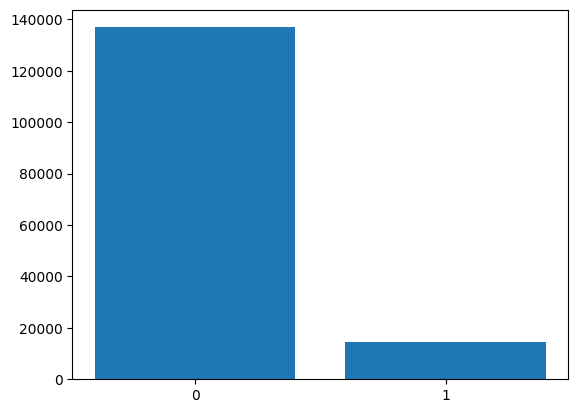

In [18]:
null_class_objs_count = (refacted_df['target'] == 0).sum()
first_class_objs_count = (refacted_df['target'] == 1).sum()
plt.figure()
plt.bar(['0', '1'], [null_class_objs_count, first_class_objs_count])



# Балансируем датасет

In [19]:
zero_target_df_part = refacted_df[refacted_df['target'] == 0].sample(n=first_class_objs_count, random_state=1)
# проверка 
ic(zero_target_df_part.shape)
ic((zero_target_df_part['target'] == 0).sum())
ic(first_class_objs_count)

ic| zero_target_df_part.shape: (14459, 26)
ic| (zero_target_df_part['target'] == 0).sum(): 14459
ic| first_class_objs_count: 14459


14459

In [20]:
first_target_df_part = refacted_df[refacted_df['target'] == 1]
balanced_df = pd.concat((zero_target_df_part, first_target_df_part), axis=0)
balanced_df.head()


,variable_1,variable_2,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,variable_12,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
66095,0.012746,0,0.015833,0.000000,0.019583,0.016907,0.000000,0,0,0.014931,...,0.023017,0.025360,0.012923,0.0,0.02429,0.0,0.020757,0.039715,0,0
98195,0.025491,0,0.009500,0.024538,0.018672,0.015266,0.017904,0,0,0.008989,...,0.000000,0.004487,0.016082,0.0,0.00000,0.0,0.020757,0.002590,0,0
37078,0.012746,0,0.007917,0.038408,0.015894,0.017904,0.000000,0,0,0.007291,...,0.023017,0.002341,0.023195,0.0,0.00000,0.0,0.020757,0.012391,0,0
9297,0.012746,0,0.017417,0.024538,0.016547,0.017904,0.000000,0,0,0.018270,...,0.023017,0.023214,0.016524,0.0,0.02429,0.0,0.020757,0.009076,0,0
110958,0.025491,0,0.015833,0.001067,0.021253,0.017233,0.017904,0,0,0.015085,...,0.000000,0.000195,0.015132,0.0,0.00000,0.0,0.020757,0.002590,0,0


Проверка

<BarContainer object of 2 artists>

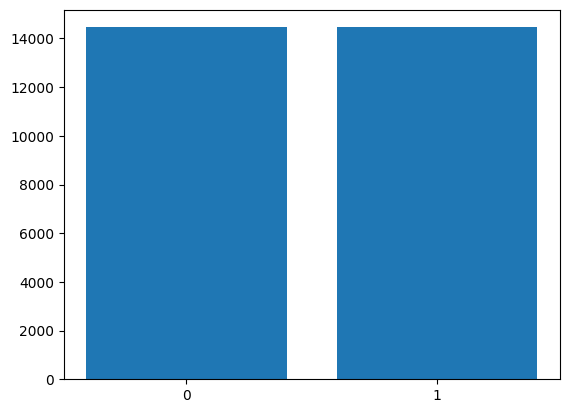

In [21]:
null_class_objs_count = (balanced_df['target'] == 0).sum()
first_class_objs_count = (balanced_df['target'] == 1).sum()
plt.figure()
plt.bar(['0', '1'], [null_class_objs_count, first_class_objs_count])

In [22]:
balanced_df.to_csv('balanced_df.csv', index=False)

# Модель 

In [26]:
class LogisticRegressionGD(object):
    
    def init(self):
        self.a = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x @ self.a))      # вектор x нужно дополнить 1 значениями в начале всех факторных признаков
    def predict(self, x):
        return self.sigmoid(x)
    def coefs(self):
        return self.a
    def LogLikelihood(self, x, Y):
        predict = self.predict(x)
        return -sum(Y * np.log2(predict) + (1 - Y) * np.log2(1 - predict)) / self.m
    def CrossEntropy(self, x, Y):
        return (-Y*np.log(self.predict(x)) - (1- Y)*np.log(1 - self.predict(x))).sum()

    def accuracy(self, x, Y):
        return 0
    
    def fit(self, x, Y, alpha = 0.001, epsylon = 0.01, max_steps = 2500, Rtype = "LL"):
        
        x.insert(0, 'ones_col', np.ones(x.shape[0]))
        self.a = np.zeros(x.shape[1]).reshape(x.shape[1], 1)
        self.m = x.shape[0]
        
        x = np.array(x)
        Y = np.array(Y)
        Y = Y.reshape(Y.shape[0], 1)

        steps, errors = [], []
        step = 0
        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.LogLikelihood(x, Y)
                dJ = x.T @ (self.predict(x) - Y) / self.m
                self.a -= alpha*dJ
            elif Rtype == "CE":
                new_error = self.CrossEntropy(x, Y)
                #display(new_error)
                dT_a = -x.T @(Y - self.predict(x))
                self.a -= alpha*dT_a
            step += 1
            steps.append(step)
            errors.append(new_error)
            if abs(new_error) < epsylon or len(steps) > max_steps:
               break
        return steps, errors

# Обучение модели

In [27]:

X = balanced_df.copy().drop(['target'], axis=1)
Y = balanced_df['target']

log_classification = LogisticRegressionGD()
steps, errors = log_classification.fit(X, Y,  alpha = 2, epsylon = 0.1, max_steps = 200, Rtype = "LL")

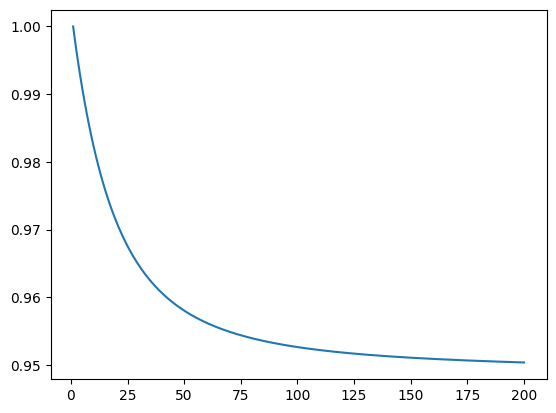

In [28]:
plt.figure()
plt.plot(steps, errors)

In [45]:
test_df = pd.read_csv('insclass_test.csv')
x_ = test_df.drop(['target'], axis=1)
x_.insert(0, 'ones_col', np.ones(x_.shape[0]))
predicts = log_classification.predict(np.array(x_))
# compare = (predicts == test_df['target'])
# compare
# test_df['target'] == predicts
binary_predicts = predicts.apply(lambda item: int(item > 0.5))
binary_predicts

AttributeError: 'numpy.ndarray' object has no attribute 'apply'